# Project 2

In this project, we have many records of several events of patients collected during their stay in the Intensive Care Unit (ICU). The objective is to predict the length of stay of a patient in a hospital admission.

Regarding the `MIMICIII` data set, we used 6 tables from it, namely `CHAREVENTS`, `ICUSTAYS`, `D_ITEMS`, `DIAGNOSES_ICD`, `PATIENTS` and `ADMISSIONS`. Information about this tables and the data set can be found [here](https://mimic.mit.edu/docs/iv/modules/icu/).

We started by uploading the data into the [Google BigQuery](https://cloud.google.com/bigquery) and then we acess it via SQL queries through the Python API.

In the following sections, we perform a statistical analysis and visualization of the data and then we build some machine learning models to predicted length of stay of a person in a admission through a set of curated features, such as information about the patient, namely its age, gender, insurance type and some of its measurements, which we know that are relevant to the disease in particular.

We focused, particulary, on 5 diseases (the most frequent ones), which are `Unspecified essential hypertension`, `Congestive heart failure, unspecified`, `Atrial fibrillation`, `Coronary atherosclerosis of native coronary artery` and `Acute kidney failure, unspecified`.

Authors:
- `Pedro Mota` (up201805248@up.pt)
- `Pedro Ferreirinha` (up201805186@up.pt)
- `Tatiana Araújo` (up201805169@up.pt)
- `Tomás Mamede` (up201706145@up.pt)

## SETUP
In this section, we will import all required libraries and create a client to acess the data set in the BigQuery platform:

In [518]:
PROJECT_ID = 'bdcc-project-2-354117'

In [519]:
!pip install seaborn
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn import metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's now create the client to acess the BigQuery. 

Add to the files in the Colab a key (in JSON format) with acess to the data set.

In [520]:
%env GOOGLE_APPLICATION_CREDENTIALS=/content/bdcc-project-2-354117-2c48dbdd7660.json

from google.cloud import bigquery
BQ_CLIENT = bigquery.Client(PROJECT_ID)

env: GOOGLE_APPLICATION_CREDENTIALS=/content/bdcc-project-2-354117-2c48dbdd7660.json


# EXPLORATORY DATA ANALYSIS

In this section, we will now explore the data, by means of summarization and visualization, as to get useful insights.

Let's start seeing how many patients that we have:

In [521]:
results = BQ_CLIENT.query(
  '''
      SELECT DISTINCT SUBJECT_ID
      FROM `{0}.icu.patients`
      ORDER BY SUBJECT_ID
  '''.format(PROJECT_ID)
).result().to_dataframe()
results.count()


SUBJECT_ID    46520
dtype: int64

We have `46520` patients, but each patient can have more than one ICU admission. 

Let's see how many admissions we have:

In [522]:
results = BQ_CLIENT.query(
  '''
      SELECT DISTINCT SUBJECT_ID, COUNT(HADM_ID) AS NUMBER_OF_ADMISSIONS
      FROM `{0}.icu.chartevents`
      GROUP BY SUBJECT_ID, HADM_ID
      ORDER BY SUBJECT_ID
  '''.format(PROJECT_ID)
).result().to_dataframe()

In [523]:
results.NUMBER_OF_ADMISSIONS.count()

57271

As we can see, we have 57272 admissions in total, more than the number of patients we have.

Let's explore the distribution of the number of admissions per patient:

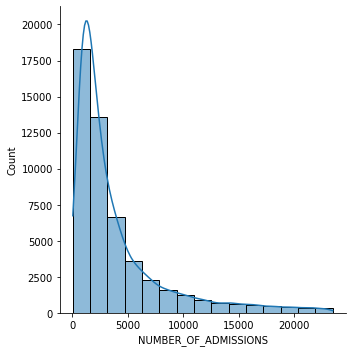

In [524]:
results = results.NUMBER_OF_ADMISSIONS[results.NUMBER_OF_ADMISSIONS.between(results.NUMBER_OF_ADMISSIONS.quantile(.05), results.NUMBER_OF_ADMISSIONS.quantile(.95))] # Remove outliers to enhance visualization
sns.displot(results, bins=15, kde=True)

From the histogram above, we can see that we have mainly patients that have come a small number of times to the ICU.


Now let's explore the various measurements made. Since each patient, in different admissions, may have different measurements, we decided to separate the data set throught the ICD that they had, because, for the same disease, the same procedure is, expected, to be followed, thus we get measurements to the same chars and we can compare within them.

In [525]:
results = BQ_CLIENT.query(
  '''
      SELECT DISTINCT ICD9_CODE, COUNT(DISTINCT SUBJECT_ID) AS N
      FROM `{0}.icu.diagnoses_icd`
      GROUP BY ICD9_CODE
      ORDER BY N DESC
  '''.format(PROJECT_ID)
).result().to_dataframe()

Let's see how many diseases we have:

In [526]:
results.ICD9_CODE.unique().size

6985

We have 6985 diseases, which are described [here](https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9).

We will choose a subset of 5 to work with. The diseases chosen were the 5 most frequent.

In [527]:
results = results.head(5)
DISEASES = results.ICD9_CODE
results

,ICD9_CODE,N
0,4019,17613
1,41401,10775
2,42731,10271
3,4280,9843
4,5849,7687


The most 5 frequent diseases are, in decreasing order: `Unspecified essential hypertension`, `Congestive heart failure, unspecified`, `Atrial fibrillation`, `Coronary atherosclerosis of native coronary artery` and 
`Acute kidney failure, unspecified`.

Now we will see how many patients have these diseases:

In [528]:
results = BQ_CLIENT.query(
  '''
      SELECT DISTINCT SUBJECT_ID
      FROM `{0}.icu.diagnoses_icd`
      WHERE ICD9_CODE IN ({1})
      ORDER BY SUBJECT_ID
  '''.format(PROJECT_ID, ','.join(map(lambda x: "'" + x + "'", list(DISEASES))))
).result().to_dataframe()
len(results.SUBJECT_ID)

28573

Let's see the distribution of these diseases relatively to the gender:

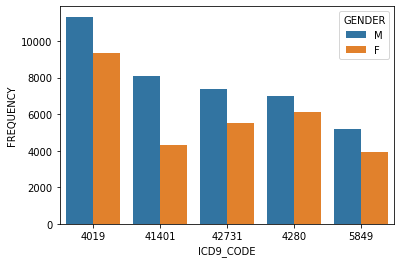

In [529]:
results = BQ_CLIENT.query(
  '''
      SELECT ICD9_CODE, GENDER, COUNT(*) AS FREQUENCY
      FROM `{0}.icu.diagnoses_icd` D
      JOIN `{0}.icu.patients` P
      ON D.SUBJECT_ID = P.SUBJECT_ID
      WHERE ICD9_CODE IN ({1})
      GROUP BY ICD9_CODE, GENDER
      ORDER BY ICD9_CODE, GENDER DESC
  '''.format(PROJECT_ID, ','.join(map(lambda x: "'" + x + "'", list(DISEASES))))
).result().to_dataframe()
sns.barplot(x="ICD9_CODE", y="FREQUENCY", hue="GENDER", data=results)

For the diseases we will explore, men tend to be the common gender.

Let’s explore the age of patients at their time of admission:

In [530]:
results = BQ_CLIENT.query(
  '''
      SELECT DISTINCT P.SUBJECT_ID, GREATEST(0,CAST(TIMESTAMP_DIFF(ADMITTIME, DOB, DAY)/365 - 0.5 AS INTEGER)) as AGE
      FROM `{0}.icu.admissions` A
      INNER JOIN `{0}.icu.patients` P 
      ON P.SUBJECT_ID = A.SUBJECT_ID
      ORDER BY P.SUBJECT_ID
  '''.format(PROJECT_ID)
).result().to_dataframe()

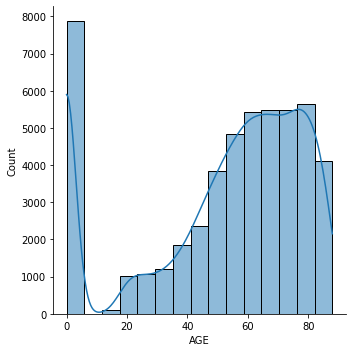

In [531]:
results = results.AGE[results.AGE.between(results.AGE.quantile(.05), results.AGE.quantile(.95))] # Remove outliers to enhance visualization
sns.displot(results, bins=15, kde=True)

As we can see from the graph above, most of our patients tend to be children or of elderly age.

Let's now see the evolution of a particular measurement, such as the <em>heart rate</em>, over time.

We can use this to explore the influence of the measurements in the length of the stay, since, usually, people leave the hospital when the values are normal.

For this, we will create a function `plot_measurement_over_time`, which given the <em>subject_id</em> and the type of <em>measurement</em> we want to see, plots the evolution of event over time of that measurement for that patient:

In [532]:
def plot_measurement_over_time(subject_id, measurement):
    results = BQ_CLIENT.query(
        '''
          SELECT I.LABEL, ARRAY_AGG(C.VALUE ORDER BY C.CHARTTIME) as VALUE
          FROM `{0}.icu.chartevents` C INNER JOIN `{0}.icu.d_items` I ON (C.ITEMID = I.ITEMID)
          WHERE SUBJECT_ID = {1} AND REGEXP_CONTAINS(C.VALUE, r"^([0-9]+\.?[0-9]*|\.[0-9]+|[0-9]+)$") AND I.LABEL = '{2}'
          GROUP BY I.LABEL
          ORDER BY array_length(VALUE) DESC
        '''.format(PROJECT_ID, 
                  subject_id, 
                  measurement)
    ).result().to_dataframe()

    x = range(0, len(results.iloc[0].VALUE))
    y = list(map(lambda s: int(s), results.iloc[0].VALUE))

    plt.xticks([])
    plt.yticks(np.arange(min(y), max(y) + 1, int((max(y) - min(y))/5)))
      
    plt.scatter(x, y)
    plt.xlabel("TIME")
    plt.ylabel(results.iloc[0].LABEL)
    plt.show()

For instance, for the patient identified by the ID 42, the evolution of its heart rate is dipicted as follows:

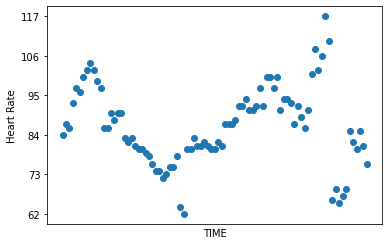

In [533]:
plot_measurement_over_time(subject_id=100, measurement='Heart Rate')

Let's see also the evolution of its respiratory rate, for the same patient:

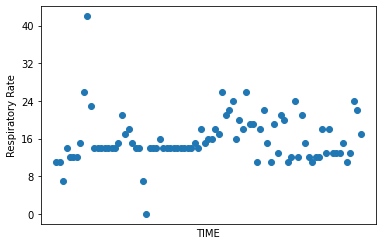

In [534]:
plot_measurement_over_time(subject_id=100, measurement='Respiratory Rate')

And, also, the evolution of its oxygen saturation: 

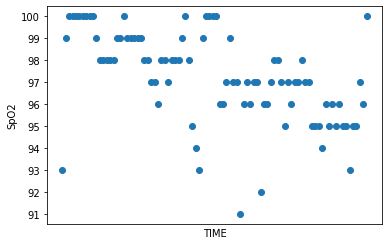

In [535]:
plot_measurement_over_time(subject_id=100, measurement='SpO2')

As we can see, there are some variations. 

These are interesting, since abnormal values/oscilations/peaks, require special observation, corresponding to a longer length of stay.

Regarding our target variable, `LOS`, let's see its distribution:

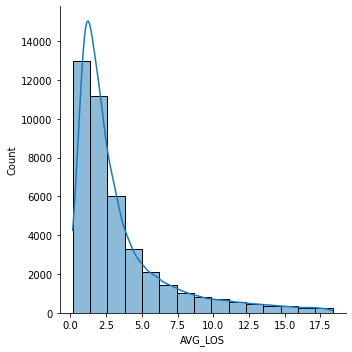

In [536]:
results = BQ_CLIENT.query(
  '''
      SELECT I.SUBJECT_ID, AVG(I.LOS) as AVG_LOS
      FROM `{0}.icu.icustays` I
      GROUP BY I.SUBJECT_ID
  '''.format(PROJECT_ID)
).result().to_dataframe()

results = results.AVG_LOS[results.AVG_LOS.between(results.AVG_LOS.quantile(.05), results.AVG_LOS.quantile(.95))] # Remove outliers to enhance visualization
sns.displot(results, bins=15, kde=True)

With this graph, we found that the majority patients stay in the hospital for less than 2 hours.

Let's see this same distribution, but with respect to the genders:

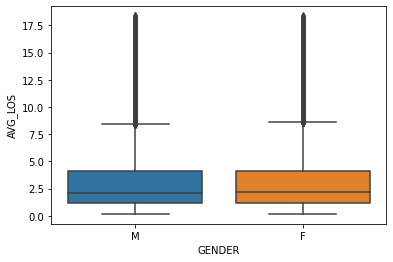

In [537]:
results = BQ_CLIENT.query(
  '''
      SELECT I.SUBJECT_ID, AVG(I.LOS) as AVG_LOS, P.GENDER
      FROM `{0}.icu.icustays` I
      INNER JOIN `{0}.icu.patients` P 
      ON P.SUBJECT_ID = I.SUBJECT_ID
      GROUP BY I.SUBJECT_ID, P.GENDER
      ORDER BY I.SUBJECT_ID, P.GENDER DESC
  '''.format(PROJECT_ID)
).result().to_dataframe()

results

results = results[results.AVG_LOS.between(results.AVG_LOS.quantile(.05), results.AVG_LOS.quantile(.95))] # Remove outliers to enhance visualization

sns.boxplot(x="GENDER", y="AVG_LOS", data=results)

Another variable that we thought it could be interesting to analyse, was the `INSURANCE`, since different insurance policies may provide specialized treatment and influence the duration of the stay.

There are 5 types of insurances (<em>Medicare, Government, Private, Medicaid, Self Pay</em>) and they have the following distribution:

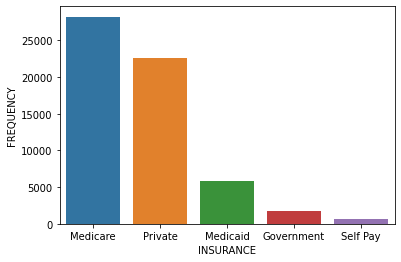

In [538]:
results = BQ_CLIENT.query(
  '''
      SELECT INSURANCE, COUNT(*) AS FREQUENCY
      FROM `{0}.icu.admissions`
      GROUP BY INSURANCE
      ORDER BY FREQUENCY DESC
  '''.format(PROJECT_ID)
).result().to_dataframe()

sns.barplot(x="INSURANCE", y="FREQUENCY", data=results)

As we can see, people tend to have health insurance plans, since there is no national health service. 

Let's see the distribution of the insurance plans regarding the length of stay:

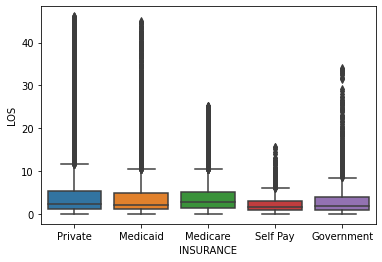

In [539]:
results = BQ_CLIENT.query(
  '''
      SELECT INSURANCE, LOS
      FROM `{0}.icu.admissions` A
      JOIN `{0}.icu.icustays` I
      ON (A.SUBJECT_ID=I.SUBJECT_ID AND A.HADM_ID=I.HADM_ID)
      GROUP BY INSURANCE, LOS
  '''.format(PROJECT_ID)
).result().to_dataframe()
results

results = results[~results.groupby('INSURANCE')['LOS'].apply(lambda s: ~s.between(s.mean() - (s.std() * 3), s.mean() + (s.std() * 3)))]

sns.boxplot(x="INSURANCE", y="LOS", data=results)

As we can see, as expected, people with insurances tend to spend more time in the ICU.

Let's now look into the relation our the patient's number of diseases with the length of stay. 

We expect patients with an higher number of diseases to stay longer, since they can be more debil and require more attention, regarding medication.

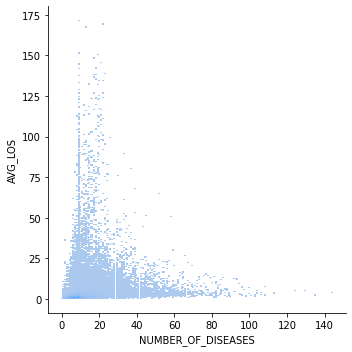

In [540]:
results = BQ_CLIENT.query(
  '''
      SELECT COUNT(DISTINCT ICD9_CODE) AS NUMBER_OF_DISEASES, AVG(I.LOS) as AVG_LOS
      FROM `{0}.icu.icustays` I
      JOIN `{0}.icu.diagnoses_icd` D
      ON I.SUBJECT_ID = D.SUBJECT_ID
      GROUP BY I.SUBJECT_ID
  '''.format(PROJECT_ID)
).result().to_dataframe()

sns.displot(results, x = "NUMBER_OF_DISEASES", y = "AVG_LOS")

Surprisingly enough, there are people with an high number of diseases, with a, relatively, small average length of stay and vice-versa! 

We did, below, the same analysis for the number of admissions and got the same results:

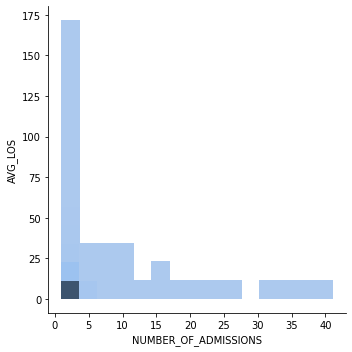

In [541]:
results = BQ_CLIENT.query(
  '''
      SELECT COUNT(HADM_ID) as NUMBER_OF_ADMISSIONS,  AVG(LOS) AS AVG_LOS
      FROM `{0}.icu.icustays` I
      GROUP BY SUBJECT_ID
  '''.format(PROJECT_ID)
).result().to_dataframe()

sns.displot(results, x = "NUMBER_OF_ADMISSIONS", y = "AVG_LOS", bins=15)

We'll now, finally start the predictive modelling.

## PREDICTIVE MODELLING

As already said, we will predict the length of stay per each disease, since the type of disease influences directly the length of the stay.

Since there are almost 7000 diseases registered, we will focus only on 5 of them. We chose the 5 most frequent.

We also converted the problem to a classification problem of 3 labels: small, medium and long length of stay.

Obviously, some measurements have a direct correlation with the disease and therefore with the length of the stay. So, with this is mind, we selected 10 of the most measurements made and then, for each disease, we complemented with significant measurements. For instance, for the disease hypertension, metrics related with blood pressure are important.

After we did this, we found out that, if we follow this heuristic, than we will have really small data set, like 40 patients, mainly because most of the measurements are not equally distributed, meaning only a few patients have made the same subset of measurements.

To compensate this, we decided then to just incorporate the 10 most frequent measurements. In this way, we mantain a good number of patients, even thought the measurement may not have a direct correlation with the disease.

Let's then get the 10 most frequent measurements:

In [628]:
items = BQ_CLIENT.query(
  '''
    SELECT ARRAY_AGG(DISTINCT C.ITEMID) AS ITEMIDS, LABEL, COUNT(*) AS N
    FROM `{0}.icu.d_items` I
    JOIN `{0}.icu.chartevents` C
    ON I.ITEMID = C.ITEMID
    GROUP BY LABEL
    ORDER BY N DESC
    LIMIT 10
  '''.format(PROJECT_ID)
).result().to_dataframe()
items

,ITEMIDS,LABEL,N
0,"[211, 220045]",Heart Rate,7943034
1,"[618, 220210]",Respiratory Rate,6123824
2,"[212, 220048]",Heart Rhythm,5326823
3,"[5815, 3450]",HR Alarm [Low],3495202
4,"[8549, 8518]",HR Alarm [High],3492603
5,[742],calprevflg,3464326
6,[646],SpO2,3418917
7,"[223758, 128]",Code Status,3252472
8,[161],Ectopy Type,3236350
9,[550],Precautions,3205052


### Disease \#1: `Unspecified essential hypertension`

In [629]:
DISEASE = 4019 # ICD9 code

Let's start by gathering information about the patients that have this disease, namely `gender`, `age`, `insurance`, `language`, `religion`, `marital status` and `ethnicity`. 

In [630]:
df = BQ_CLIENT.query(
  '''
    SELECT A.HADM_ID, GENDER, GREATEST(0,CAST(TIMESTAMP_DIFF(ADMITTIME, DOB, DAY)/365 - 0.5 AS INTEGER)) as AGE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
    FROM `{0}.icu.admissions` A
    INNER JOIN `{0}.icu.patients` P 
    ON P.SUBJECT_ID = A.SUBJECT_ID
    INNER JOIN `{0}.icu.diagnoses_icd` D
    ON P.SUBJECT_ID = D.SUBJECT_ID
    WHERE ICD9_CODE = '{1}'
    GROUP BY A.HADM_ID, GENDER, AGE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
    ORDER BY HADM_ID
  '''.format(PROJECT_ID, DISEASE)
).result().to_dataframe()
df = df[df.AGE.between(0, 120)]
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY
0,100003,M,59,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE
1,100006,F,48,Private,None,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN
2,100007,F,73,Private,None,JEWISH,MARRIED,WHITE
3,100009,M,60,Private,None,CATHOLIC,MARRIED,WHITE
4,100012,M,67,Medicare,ENGL,CATHOLIC,MARRIED,WHITE
...,...,...,...,...,...,...,...,...
24713,199972,M,78,Medicare,ENGL,CATHOLIC,MARRIED,WHITE
24714,199979,M,79,Medicare,ENGL,PROTESTANT QUAKER,SINGLE,WHITE
24716,199986,F,73,Medicare,None,PROTESTANT QUAKER,WIDOWED,WHITE
24717,199994,F,58,Medicare,None,CATHOLIC,SINGLE,WHITE


Let's now get the measurements for the most common ones. 

We will get a value for each label. 

When there's more than one value, in the same admission, we will consider the min and max value measured.

In [631]:
for index, row in items.iterrows():
  if index == 8: break
  measurement = BQ_CLIENT.query(
    '''
        SELECT HADM_ID, MIN(VALUE) AS {0}_Min_Registered, MAX(VALUE) AS {0}_Max_Registered
        FROM `{1}.icu.chartevents` C
        WHERE HADM_ID IN ({2}) AND ITEMID IN ({3}) 
        GROUP BY HADM_ID
        ORDER BY HADM_ID
    '''.format(row.LABEL.replace(" ", "").replace("[", "_").replace("]", "_"),
              PROJECT_ID, 
              ','.join(map(lambda i: str(i), list(df.HADM_ID))),
              ','.join(map(lambda i: str(i), list(row.ITEMIDS))))
  ).result().to_dataframe()
  df = pd.merge(df, measurement, on="HADM_ID")
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,...,HRAlarm_Low__Min_Registered,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered
0,100007,F,73,Private,None,JEWISH,MARRIED,WHITE,100,99,...,50,60,110,120,1,1,100,99,Full Code,Full Code
1,100021,M,54,Medicaid,SPAN,UNOBTAINABLE,MARRIED,HISPANIC OR LATINO,100,99,...,50,90,120,130,1,1,100,99,Full Code,Full Code
2,100038,F,57,Medicaid,SPAN,CATHOLIC,SINGLE,HISPANIC OR LATINO,61,72,...,50,50,125,125,1,1,100,99,Full Code,Full Code
3,100059,M,68,Medicare,None,CATHOLIC,MARRIED,WHITE,100,99,...,60,60,120,120,1,1,100,99,Full Code,Full Code
4,100065,M,59,Private,ENGL,NOT SPECIFIED,MARRIED,BLACK/AFRICAN AMERICAN,70,90,...,50,50,120,120,1,1,100,99,Full Code,Full Code
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8189,199947,M,83,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,100,98,...,40,60,100,130,1,1,100,99,Full Code,Full Code
8190,199952,M,84,Private,ITAL,NOT SPECIFIED,MARRIED,WHITE,62,80,...,55,70,125,125,1,1,100,99,Full Code,Full Code
8191,199963,M,70,Medicare,None,OTHER,SINGLE,UNKNOWN/NOT SPECIFIED,100,99,...,50,60,100,120,1,1,100,99,Full Code,Full Code
8192,199969,F,82,Medicare,None,CATHOLIC,WIDOWED,WHITE,100,99,...,60,60,120,120,1,1,100,99,Full Code,Full Code


In [632]:
df = df.dropna()
df.shape

(4661, 24)

Let's now get the target variable, `LOS`:

In [633]:
results = BQ_CLIENT.query(
  '''
      SELECT HADM_ID, AVG(LOS) AS LOS
      FROM `{0}.icu.icustays`
      WHERE HADM_ID IN ({1})
      GROUP BY HADM_ID
      ORDER BY HADM_ID
  '''.format(PROJECT_ID, 
             ','.join(map(lambda i: str(i), list(df.HADM_ID))))
).result().to_dataframe()

results.LOS = np.digitize(results.LOS,[4,7])

df = pd.merge(df, results, on="HADM_ID")

results.LOS

0       0
1       0
2       0
3       0
4       0
       ..
4650    0
4651    2
4652    0
4653    1
4654    0
Name: LOS, Length: 4655, dtype: int64

Let's convert the categorical features to numeric features, since <em>Scikit Learn</em> only works with numeric data:

In [634]:
cols = ['GENDER', 'AGE', 'INSURANCE',
        'HeartRhythm_Min_Registered',  'HeartRhythm_Max_Registered',
        'CodeStatus_Min_Registered', 'CodeStatus_Max_Registered'
]

for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,...,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered,LOS
0,0,1,35,1,30,15,1,11,1,66,...,28,6,10,0,0,3,15,7,3,0
1,1,0,38,1,30,2,3,11,79,38,...,11,7,7,0,0,3,15,7,3,0
2,2,1,40,3,16,10,1,8,88,56,...,11,6,5,0,0,3,15,7,3,0
3,3,0,62,2,16,2,5,27,2,59,...,15,6,5,0,0,3,15,7,3,0
4,4,0,39,3,16,2,1,27,14,54,...,14,3,11,0,0,3,15,7,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,4650,1,50,2,16,15,4,27,74,56,...,11,6,5,0,0,3,15,7,3,0
4651,4651,1,42,1,27,15,5,27,1,66,...,15,4,7,0,0,3,15,7,3,2
4652,4652,1,50,3,16,2,5,27,1,64,...,15,3,5,0,0,3,15,7,3,0
4653,4653,1,65,3,21,10,1,27,80,46,...,21,7,7,0,0,3,15,7,3,1


We can already drop the `HADM_ID` feature and also normalize the data:

In [635]:
df = df.drop('HADM_ID', axis=1)

df.loc[:, df.columns != 'LOS'] = pd.DataFrame(MinMaxScaler().fit_transform(df.loc[:, df.columns != 'LOS']), columns=df.loc[:, df.columns != 'LOS'].columns)

Final glimpse on the data set:

In [636]:
df

,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,RespiratoryRate_Min_Registered,...,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered,LOS
0,1.0,0.500000,0.25,0.93750,1.000000,0.2,0.354839,0.009524,0.970588,0.277778,...,0.933333,0.272727,0.256410,0.0,0.0,0.076923,1.0,0.777778,0.6,0
1,0.0,0.542857,0.25,0.93750,0.133333,0.6,0.354839,0.752381,0.558824,0.555556,...,0.366667,0.318182,0.179487,0.0,0.0,0.076923,1.0,0.777778,0.6,0
2,1.0,0.571429,0.75,0.50000,0.666667,0.2,0.258065,0.838095,0.823529,0.555556,...,0.366667,0.272727,0.128205,0.0,0.0,0.076923,1.0,0.777778,0.6,0
3,0.0,0.885714,0.50,0.50000,0.133333,1.0,0.870968,0.019048,0.867647,0.111111,...,0.500000,0.272727,0.128205,0.0,0.0,0.076923,1.0,0.777778,0.6,0
4,0.0,0.557143,0.75,0.50000,0.133333,0.2,0.870968,0.133333,0.794118,0.500000,...,0.466667,0.136364,0.282051,0.0,0.0,0.076923,1.0,0.777778,0.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,1.0,0.714286,0.50,0.50000,1.000000,0.8,0.870968,0.704762,0.823529,0.111111,...,0.366667,0.272727,0.128205,0.0,0.0,0.076923,1.0,0.777778,0.6,0
4651,1.0,0.600000,0.25,0.84375,1.000000,1.0,0.870968,0.009524,0.970588,0.111111,...,0.500000,0.181818,0.179487,0.0,0.0,0.076923,1.0,0.777778,0.6,2
4652,1.0,0.714286,0.75,0.50000,0.133333,1.0,0.870968,0.009524,0.941176,0.333333,...,0.500000,0.136364,0.128205,0.0,0.0,0.076923,1.0,0.777778,0.6,0
4653,1.0,0.928571,0.75,0.65625,0.666667,0.2,0.870968,0.761905,0.676471,0.388889,...,0.700000,0.318182,0.179487,0.0,0.0,0.076923,1.0,0.777778,0.6,1


Let's now train our models, with a Random Forest, XGBoost and Multi-Layer Perceptron classifier.

Firstly, let's start by spliting our data set into a training and testing set.

In [637]:
X = df.drop(["LOS"], axis=1)
y = df["LOS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- **Random Forests**

In [638]:
model = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [639]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted')))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.76
precision: 0.70
recall: 0.76
f1_score: 0.71


The 5 most important features:

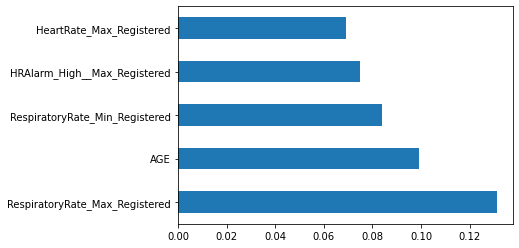

In [640]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(5).plot(kind='barh')

- **XGBOOST**

In [641]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [642]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted')))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.76
precision: 0.68
recall: 0.76
f1_score: 0.71


The 5 most important features:

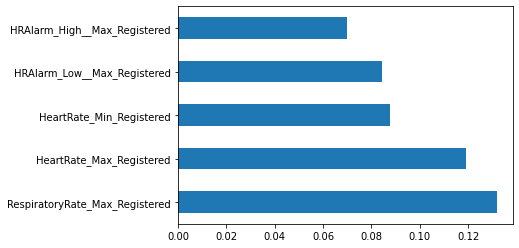

In [643]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(5).plot(kind='barh')

- **Multi-Layer Perceptron (MLP)** 

In [644]:
model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(8, 2), max_iter = 500, random_state=42)

model.fit(X,y)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [645]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted', labels=np.unique(predictions))))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.72
precision: 0.72
recall: 0.72
f1_score: 0.60


Our best model was the Random Forest, with an accuracy of 76%, a precision of 70%, a recall of 76% and a f1_score of 71%.

### Disease \#2: `Congestive heart failure, unspecified`

In [646]:
DISEASE = 41401 # ICD9 code

Let's start by gathering information about the patients that have this disease, namely `gender`, `age`, `insurance`, `language`, `religion`, `marital status` and `ethnicity`. 

In [647]:
df = BQ_CLIENT.query(
  '''
    SELECT A.HADM_ID, GENDER, GREATEST(0,CAST(TIMESTAMP_DIFF(ADMITTIME, DOB, DAY)/365 - 0.5 AS INTEGER)) as AGE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
    FROM `{0}.icu.admissions` A
    INNER JOIN `{0}.icu.patients` P 
    ON P.SUBJECT_ID = A.SUBJECT_ID
    INNER JOIN `{0}.icu.diagnoses_icd` D
    ON P.SUBJECT_ID = D.SUBJECT_ID
    WHERE ICD9_CODE = '{1}'
    GROUP BY A.HADM_ID, GENDER, AGE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
    ORDER BY HADM_ID
  '''.format(PROJECT_ID, DISEASE)
).result().to_dataframe()
df = df[df.AGE.between(0, 120)]
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY
0,100009,M,60,Private,None,CATHOLIC,MARRIED,WHITE
1,100012,M,67,Medicare,ENGL,CATHOLIC,MARRIED,WHITE
2,100018,M,55,Private,ENGL,PROTESTANT QUAKER,MARRIED,WHITE
3,100024,M,71,Medicare,ENGL,NOT SPECIFIED,MARRIED,UNKNOWN/NOT SPECIFIED
4,100034,M,68,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE
...,...,...,...,...,...,...,...,...
15371,199969,F,82,Medicare,None,CATHOLIC,WIDOWED,WHITE
15372,199979,M,79,Medicare,ENGL,PROTESTANT QUAKER,SINGLE,WHITE
15375,199986,F,73,Medicare,None,PROTESTANT QUAKER,WIDOWED,WHITE
15376,199998,M,69,Medicare,ENGL,CATHOLIC,MARRIED,WHITE


Let's now get the measurements for the most common ones. 

We will get a value for each label. 

When there's more than one value, in the same admission, we will consider the min and max value measured.

In [648]:
for index, row in items.iterrows():
  if index == 8: break
  measurement = BQ_CLIENT.query(
    '''
        SELECT HADM_ID, MIN(VALUE) AS {0}_Min_Registered, MAX(VALUE) AS {0}_Max_Registered
        FROM `{1}.icu.chartevents` C
        WHERE HADM_ID IN ({2}) AND ITEMID IN ({3}) 
        GROUP BY HADM_ID
        ORDER BY HADM_ID
    '''.format(row.LABEL.replace(" ", "").replace("[", "_").replace("]", "_"),
              PROJECT_ID, 
              ','.join(map(lambda i: str(i), list(df.HADM_ID))),
              ','.join(map(lambda i: str(i), list(row.ITEMIDS))))
  ).result().to_dataframe()
  df = pd.merge(df, measurement, on="HADM_ID")
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,...,HRAlarm_Low__Min_Registered,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered
0,100036,F,82,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,104,97,...,60,60,120,120,1,1,100,99,Full Code,Full Code
1,100050,M,69,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,60,97,...,50,50,100,115,1,1,100,99,Full Code,Full Code
2,100059,M,68,Medicare,None,CATHOLIC,MARRIED,WHITE,100,99,...,60,60,120,120,1,1,100,99,Full Code,Full Code
3,100088,F,74,Medicare,None,CATHOLIC,WIDOWED,WHITE,47,97,...,45,60,120,120,1,1,100,99,Full Code,Full Code
4,100095,M,84,Medicare,None,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,100,99,...,50,50,120,130,1,1,100,99,Do Not Resuscita,Full Code
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4979,199955,M,55,Private,None,NOT SPECIFIED,MARRIED,BLACK/AFRICAN AMERICAN,0,97,...,50,50,120,120,1,1,100,99,Full Code,Full Code
4980,199956,F,77,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,65,94,...,50,60,120,120,1,1,100,99,Full Code,Full Code
4981,199963,M,70,Medicare,None,OTHER,SINGLE,UNKNOWN/NOT SPECIFIED,100,99,...,50,60,100,120,1,1,100,99,Full Code,Full Code
4982,199969,F,82,Medicare,None,CATHOLIC,WIDOWED,WHITE,100,99,...,60,60,120,120,1,1,100,99,Full Code,Full Code


In [649]:
df = df.dropna()
df.shape

(2865, 24)

Let's now get the target variable, `LOS`:

In [650]:
results = BQ_CLIENT.query(
  '''
      SELECT HADM_ID, AVG(LOS) AS LOS
      FROM `{0}.icu.icustays`
      WHERE HADM_ID IN ({1})
      GROUP BY HADM_ID
      ORDER BY HADM_ID
  '''.format(PROJECT_ID, 
             ','.join(map(lambda i: str(i), list(df.HADM_ID))))
).result().to_dataframe()

results.LOS = np.digitize(results.LOS,[4,7])

df = pd.merge(df, results, on="HADM_ID")

results.LOS

0       0
1       0
2       0
3       0
4       0
       ..
2859    2
2860    0
2861    2
2862    0
2863    0
Name: LOS, Length: 2864, dtype: int64

Let's convert the categorical features to numeric features, since <em>Scikit Learn</em> only works with numeric data:

In [651]:
cols = ['GENDER', 'AGE', 'INSURANCE',
        'HeartRhythm_Min_Registered',  'HeartRhythm_Max_Registered',
        'CodeStatus_Min_Registered', 'CodeStatus_Max_Registered'
]

for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,...,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered,LOS
0,0,0,49,2,11,1,3,26,5,50,...,13,8,5,0,0,4,10,6,3,0
1,1,1,36,2,11,1,1,26,65,50,...,9,1,3,0,0,4,10,6,3,0
2,2,0,25,3,11,1,1,26,14,41,...,11,5,9,0,0,4,10,6,3,0
3,3,1,48,2,11,7,1,26,52,30,...,9,8,5,0,0,4,10,6,3,0
4,4,1,28,2,11,1,1,26,1,52,...,13,8,5,0,0,4,10,6,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,2859,0,37,2,11,1,5,26,1,52,...,13,5,8,0,0,4,10,6,3,2
2860,2860,1,41,2,11,1,5,26,58,34,...,9,8,5,0,0,23,9,6,3,0
2861,2861,1,28,1,21,14,5,26,1,52,...,13,6,7,0,0,4,10,6,3,2
2862,2862,0,44,2,11,1,3,26,70,47,...,13,8,5,0,0,4,10,6,3,0


We can already drop the `HADM_ID` feature and also normalize the data:

In [652]:
df = df.drop('HADM_ID', axis=1)

df.loc[:, df.columns != 'LOS'] = pd.DataFrame(MinMaxScaler().fit_transform(df.loc[:, df.columns != 'LOS']), columns=df.loc[:, df.columns != 'LOS'].columns)

Final glimpse on the data set:

In [653]:
df

,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,RespiratoryRate_Min_Registered,...,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered,LOS
0,0.0,0.875000,0.50,0.407407,0.071429,0.6,0.896552,0.057471,0.943396,0.200000,...,0.590909,0.363636,0.166667,0.0,0.0,0.121212,1.0,0.857143,0.6,0
1,1.0,0.642857,0.50,0.407407,0.071429,0.2,0.896552,0.747126,0.943396,0.200000,...,0.409091,0.045455,0.100000,0.0,0.0,0.121212,1.0,0.857143,0.6,0
2,0.0,0.446429,0.75,0.407407,0.071429,0.2,0.896552,0.160920,0.773585,0.533333,...,0.500000,0.227273,0.300000,0.0,0.0,0.121212,1.0,0.857143,0.6,0
3,1.0,0.857143,0.50,0.407407,0.500000,0.2,0.896552,0.597701,0.566038,0.133333,...,0.409091,0.363636,0.166667,0.0,0.0,0.121212,1.0,0.857143,0.6,0
4,1.0,0.500000,0.50,0.407407,0.071429,0.2,0.896552,0.011494,0.981132,0.133333,...,0.590909,0.363636,0.166667,0.0,0.0,0.121212,1.0,0.857143,0.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,0.0,0.660714,0.50,0.407407,0.071429,1.0,0.896552,0.011494,0.981132,0.200000,...,0.590909,0.227273,0.266667,0.0,0.0,0.121212,1.0,0.857143,0.6,2
2860,1.0,0.732143,0.50,0.407407,0.071429,1.0,0.896552,0.666667,0.641509,0.533333,...,0.409091,0.363636,0.166667,0.0,0.0,0.696970,0.9,0.857143,0.6,0
2861,1.0,0.500000,0.25,0.777778,1.000000,1.0,0.896552,0.011494,0.981132,0.133333,...,0.590909,0.272727,0.233333,0.0,0.0,0.121212,1.0,0.857143,0.6,2
2862,0.0,0.785714,0.50,0.407407,0.071429,0.6,0.896552,0.804598,0.886792,0.400000,...,0.590909,0.363636,0.166667,0.0,0.0,0.121212,1.0,0.857143,0.6,0


Let's now train our models, with a Random Forest, XGBoost and Multi-Layer Perceptron classifier.

Firstly, let's start by spliting our data set into a training and testing set.

In [654]:
X = df.drop(["LOS"], axis=1)
y = df["LOS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- **Random Forests**

In [655]:
model = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [656]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted')))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.82
precision: 0.75
recall: 0.82
f1_score: 0.78


The 5 most important features:

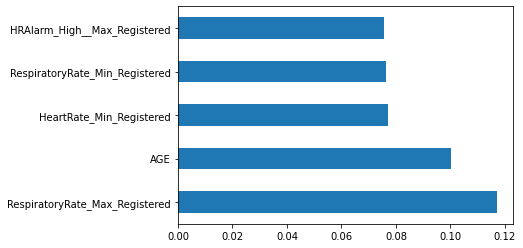

In [657]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(5).plot(kind='barh')

- **XGBOOST**

In [658]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [659]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted')))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.82
precision: 0.75
recall: 0.82
f1_score: 0.77


The 5 most important features:

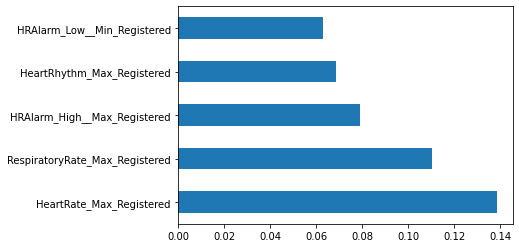

In [660]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(5).plot(kind='barh')

- **Multi-Layer Perceptron (MLP)** 

In [661]:
model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(8, 2), max_iter = 500, random_state=42)

model.fit(X,y)

predictions = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Let's acess the performance of our model:

In [662]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted', labels=np.unique(predictions))))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.82
precision: 0.82
recall: 0.82
f1_score: 0.77


 All models have the same accuracy, precision and recall, so we chose the model with the higest f1_score which was the Random Forest, with an accuracy of 82%, precision of 82%, reacall of 82% and f1_score of 77%.

### Disease \#3: `Atrial fibrillation`

In [663]:
DISEASE = 42731 # ICD9 code

Let's start by gathering information about the patients that have this disease, namely `gender`, `age`, `insurance`, `language`, `religion`, `marital status` and `ethnicity`. 

In [664]:
df = BQ_CLIENT.query(
  '''
    SELECT A.HADM_ID, GENDER, GREATEST(0,CAST(TIMESTAMP_DIFF(ADMITTIME, DOB, DAY)/365 - 0.5 AS INTEGER)) as AGE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
    FROM `{0}.icu.admissions` A
    INNER JOIN `{0}.icu.patients` P 
    ON P.SUBJECT_ID = A.SUBJECT_ID
    INNER JOIN `{0}.icu.diagnoses_icd` D
    ON P.SUBJECT_ID = D.SUBJECT_ID
    WHERE ICD9_CODE = '{1}'
    GROUP BY A.HADM_ID, GENDER, AGE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
    ORDER BY HADM_ID
  '''.format(PROJECT_ID, DISEASE)
).result().to_dataframe()
df = df[df.AGE.between(0, 120)]
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY
0,100018,M,55,Private,ENGL,PROTESTANT QUAKER,MARRIED,WHITE
1,100021,M,54,Medicaid,SPAN,UNOBTAINABLE,MARRIED,HISPANIC OR LATINO
2,100024,M,71,Medicare,ENGL,NOT SPECIFIED,MARRIED,UNKNOWN/NOT SPECIFIED
3,100028,F,72,Medicare,ENGL,CATHOLIC,SINGLE,WHITE
4,100031,F,81,Medicare,None,CATHOLIC,MARRIED,WHITE
...,...,...,...,...,...,...,...,...
14924,199972,M,78,Medicare,ENGL,CATHOLIC,MARRIED,WHITE
14925,199979,M,79,Medicare,ENGL,PROTESTANT QUAKER,SINGLE,WHITE
14927,199993,M,60,Private,None,CATHOLIC,DIVORCED,UNKNOWN/NOT SPECIFIED
14928,199994,F,58,Medicare,None,CATHOLIC,SINGLE,WHITE


Let's now get the measurements for the most common ones. 

We will get a value for each label. 

When there's more than one value, in the same admission, we will consider the min and max value measured.

In [665]:
for index, row in items.iterrows():
  if index == 8: break
  measurement = BQ_CLIENT.query(
    '''
        SELECT HADM_ID, MIN(VALUE) AS {0}_Min_Registered, MAX(VALUE) AS {0}_Max_Registered
        FROM `{1}.icu.chartevents` C
        WHERE HADM_ID IN ({2}) AND ITEMID IN ({3}) 
        GROUP BY HADM_ID
        ORDER BY HADM_ID
    '''.format(row.LABEL.replace(" ", "").replace("[", "_").replace("]", "_"),
              PROJECT_ID, 
              ','.join(map(lambda i: str(i), list(df.HADM_ID))),
              ','.join(map(lambda i: str(i), list(row.ITEMIDS))))
  ).result().to_dataframe()
  df = pd.merge(df, measurement, on="HADM_ID")
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,...,HRAlarm_Low__Min_Registered,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered
0,100021,M,54,Medicaid,SPAN,UNOBTAINABLE,MARRIED,HISPANIC OR LATINO,100,99,...,50,90,120,130,1,1,100,99,Full Code,Full Code
1,100036,F,82,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,104,97,...,60,60,120,120,1,1,100,99,Full Code,Full Code
2,100050,M,69,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,60,97,...,50,50,100,115,1,1,100,99,Full Code,Full Code
3,100053,M,56,Private,None,NOT SPECIFIED,SINGLE,WHITE,0,99,...,60,70,120,140,1,1,100,99,Do Not Resuscita,Full Code
4,100088,F,74,Medicare,None,CATHOLIC,WIDOWED,WHITE,47,97,...,45,60,120,120,1,1,100,99,Full Code,Full Code
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4737,199919,F,65,Private,None,PROTESTANT QUAKER,MARRIED,UNKNOWN/NOT SPECIFIED,106,98,...,55,60,120,120,1,1,100,99,Do Not Resuscita,Full Code
4738,199947,M,83,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,100,98,...,40,60,100,130,1,1,100,99,Full Code,Full Code
4739,199952,M,84,Private,ITAL,NOT SPECIFIED,MARRIED,WHITE,62,80,...,55,70,125,125,1,1,100,99,Full Code,Full Code
4740,199969,F,82,Medicare,None,CATHOLIC,WIDOWED,WHITE,100,99,...,60,60,120,120,1,1,100,99,Full Code,Full Code


In [666]:
df = df.dropna()
df.shape

(2583, 24)

Let's now get the target variable, `LOS`:

In [667]:
results = BQ_CLIENT.query(
  '''
      SELECT HADM_ID, AVG(LOS) AS LOS
      FROM `{0}.icu.icustays`
      WHERE HADM_ID IN ({1})
      GROUP BY HADM_ID
      ORDER BY HADM_ID
  '''.format(PROJECT_ID, 
             ','.join(map(lambda i: str(i), list(df.HADM_ID))))
).result().to_dataframe()

results.LOS = np.digitize(results.LOS,[4,7])

df = pd.merge(df, results, on="HADM_ID")

results.LOS

0       0
1       0
2       0
3       0
4       0
       ..
2577    0
2578    0
2579    2
2580    1
2581    0
Name: LOS, Length: 2582, dtype: int64

Let's convert the categorical features to numeric features, since <em>Scikit Learn</em> only works with numeric data:

In [668]:
cols = ['GENDER', 'AGE', 'INSURANCE',
        'HeartRhythm_Min_Registered',  'HeartRhythm_Max_Registered',
        'CodeStatus_Min_Registered', 'CodeStatus_Max_Registered'
]

for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,...,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered,LOS
0,0,1,27,1,27,15,1,7,1,52,...,22,8,10,0,0,3,12,7,3,0
1,1,0,55,2,14,2,3,20,5,50,...,10,8,5,0,0,3,12,7,3,0
2,2,1,42,2,14,2,1,20,68,50,...,8,2,3,0,0,3,12,7,3,0
3,3,0,54,2,14,2,5,20,2,46,...,10,8,5,0,0,3,12,7,3,0
4,4,0,31,3,14,2,1,20,14,41,...,9,5,11,0,0,3,12,7,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,2577,0,53,2,14,10,1,20,5,52,...,8,8,10,0,0,3,12,7,3,0
2578,2578,1,50,2,14,12,1,20,1,52,...,8,8,5,0,0,3,12,7,3,0
2579,2579,0,43,2,14,2,5,20,1,52,...,10,5,10,0,0,3,12,7,3,2
2580,2580,1,57,3,17,10,1,20,70,33,...,17,9,7,0,0,3,12,7,3,1


We can already drop the `HADM_ID` feature and also normalize the data:

In [669]:
df = df.drop('HADM_ID', axis=1)

df.loc[:, df.columns != 'LOS'] = pd.DataFrame(MinMaxScaler().fit_transform(df.loc[:, df.columns != 'LOS']), columns=df.loc[:, df.columns != 'LOS'].columns)

Final glimpse on the data set:

In [670]:
df

,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,RespiratoryRate_Min_Registered,...,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered,LOS
0,1.0,0.435484,0.25,0.900000,1.000000,0.2,0.291667,0.010870,1.000000,0.263158,...,0.956522,0.333333,0.243902,0.0,0.0,0.083333,1.0,0.875,0.6,0
1,0.0,0.887097,0.50,0.466667,0.133333,0.6,0.833333,0.054348,0.961538,0.210526,...,0.434783,0.333333,0.121951,0.0,0.0,0.083333,1.0,0.875,0.6,0
2,1.0,0.677419,0.50,0.466667,0.133333,0.2,0.833333,0.739130,0.961538,0.210526,...,0.347826,0.083333,0.073171,0.0,0.0,0.083333,1.0,0.875,0.6,0
3,0.0,0.870968,0.50,0.466667,0.133333,1.0,0.833333,0.021739,0.884615,0.105263,...,0.434783,0.333333,0.121951,0.0,0.0,0.083333,1.0,0.875,0.6,0
4,0.0,0.500000,0.75,0.466667,0.133333,0.2,0.833333,0.152174,0.788462,0.473684,...,0.391304,0.208333,0.268293,0.0,0.0,0.083333,1.0,0.875,0.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,0.0,0.854839,0.50,0.466667,0.666667,0.2,0.833333,0.054348,1.000000,0.368421,...,0.347826,0.333333,0.243902,0.0,0.0,0.083333,1.0,0.875,0.6,0
2578,1.0,0.806452,0.50,0.466667,0.800000,0.2,0.833333,0.010870,1.000000,0.105263,...,0.347826,0.333333,0.121951,0.0,0.0,0.083333,1.0,0.875,0.6,0
2579,0.0,0.693548,0.50,0.466667,0.133333,1.0,0.833333,0.010870,1.000000,0.210526,...,0.434783,0.208333,0.243902,0.0,0.0,0.083333,1.0,0.875,0.6,2
2580,1.0,0.919355,0.75,0.566667,0.666667,0.2,0.833333,0.760870,0.634615,0.368421,...,0.739130,0.375000,0.170732,0.0,0.0,0.083333,1.0,0.875,0.6,1


Let's now train our models, with a Random Forest, XGBoost and Multi-Layer Perceptron classifier.

Firstly, let's start by spliting our data set into a training and testing set.

In [671]:
X = df.drop(["LOS"], axis=1)
y = df["LOS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- **Random Forests**

In [672]:
model = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [673]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted')))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.73
precision: 0.67
recall: 0.73
f1_score: 0.68


The 5 most important features:

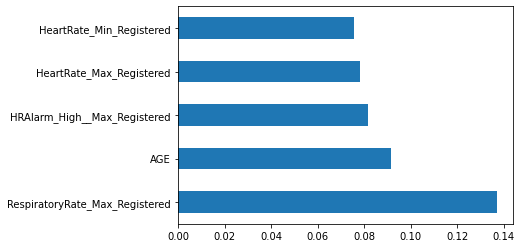

In [674]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(5).plot(kind='barh')

- **XGBOOST**

In [675]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [676]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted')))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.73
precision: 0.67
recall: 0.73
f1_score: 0.68


The 5 most important features:

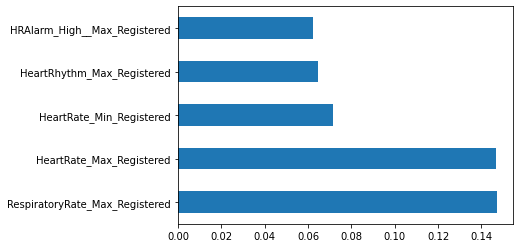

In [677]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(5).plot(kind='barh')

- **Multi-Layer Perceptron (MLP)** 

In [678]:
model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(8, 2), max_iter = 500, random_state=42)

model.fit(X,y)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [679]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted', labels=np.unique(predictions))))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.64
precision: 0.64
recall: 0.64
f1_score: 0.50


We have the similar results for Random Forest and for XGBoost, both with an accuracy of 73%.



### Disease \#4: `Coronary atherosclerosis of native coronary artery`

In [680]:
DISEASE = 4280 # ICD9 code

Let's start by gathering information about the patients that have this disease, namely `gender`, `age`, `insurance`, `language`, `religion`, `marital status` and `ethnicity`. 

In [681]:
df = BQ_CLIENT.query(
  '''
    SELECT A.HADM_ID, GENDER, GREATEST(0,CAST(TIMESTAMP_DIFF(ADMITTIME, DOB, DAY)/365 - 0.5 AS INTEGER)) as AGE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
    FROM `{0}.icu.admissions` A
    INNER JOIN `{0}.icu.patients` P 
    ON P.SUBJECT_ID = A.SUBJECT_ID
    INNER JOIN `{0}.icu.diagnoses_icd` D
    ON P.SUBJECT_ID = D.SUBJECT_ID
    WHERE ICD9_CODE = '{1}'
    GROUP BY A.HADM_ID, GENDER, AGE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
    ORDER BY HADM_ID
  '''.format(PROJECT_ID, DISEASE)
).result().to_dataframe()
df = df[df.AGE.between(0, 120)]
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY
0,100018,M,55,Private,ENGL,PROTESTANT QUAKER,MARRIED,WHITE
1,100019,M,27,Private,None,OTHER,MARRIED,WHITE
2,100020,M,58,Private,ENGL,CATHOLIC,MARRIED,WHITE
3,100035,M,36,Medicaid,SPAN,NOT SPECIFIED,SINGLE,HISPANIC OR LATINO
4,100036,F,82,Medicare,ENGL,CATHOLIC,SINGLE,WHITE
...,...,...,...,...,...,...,...,...
16234,199963,M,70,Medicare,None,OTHER,SINGLE,UNKNOWN/NOT SPECIFIED
16235,199969,F,82,Medicare,None,CATHOLIC,WIDOWED,WHITE
16236,199972,M,78,Medicare,ENGL,CATHOLIC,MARRIED,WHITE
16238,199994,F,58,Medicare,None,CATHOLIC,SINGLE,WHITE


Let's now get the measurements for the most common ones. 

We will get a value for each label. 

When there's more than one value, in the same admission, we will consider the min and max value measured.

In [682]:
for index, row in items.iterrows():
  if index == 8: break
  measurement = BQ_CLIENT.query(
    '''
        SELECT HADM_ID, MIN(VALUE) AS {0}_Min_Registered, MAX(VALUE) AS {0}_Max_Registered
        FROM `{1}.icu.chartevents` C
        WHERE HADM_ID IN ({2}) AND ITEMID IN ({3}) 
        GROUP BY HADM_ID
        ORDER BY HADM_ID
    '''.format(row.LABEL.replace(" ", "").replace("[", "_").replace("]", "_"),
              PROJECT_ID, 
              ','.join(map(lambda i: str(i), list(df.HADM_ID))),
              ','.join(map(lambda i: str(i), list(row.ITEMIDS))))
  ).result().to_dataframe()
  df = pd.merge(df, measurement, on="HADM_ID")
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,...,HRAlarm_Low__Min_Registered,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered
0,100036,F,82,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,104,97,...,60,60,120,120,1,1,100,99,Full Code,Full Code
1,100045,F,69,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,100,98,...,40,50,120,140,1,1,100,99,Full Code,Full Code
2,100050,M,69,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,60,97,...,50,50,100,115,1,1,100,99,Full Code,Full Code
3,100095,M,84,Medicare,None,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,100,99,...,50,50,120,130,1,1,100,99,Do Not Resuscita,Full Code
4,100136,F,58,Private,ENGL,CATHOLIC,MARRIED,WHITE,113,88,...,50,55,110,135,1,1,100,99,Full Code,Full Code
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5380,199952,M,84,Private,ITAL,NOT SPECIFIED,MARRIED,WHITE,62,80,...,55,70,125,125,1,1,100,99,Full Code,Full Code
5381,199955,M,55,Private,None,NOT SPECIFIED,MARRIED,BLACK/AFRICAN AMERICAN,0,97,...,50,50,120,120,1,1,100,99,Full Code,Full Code
5382,199963,M,70,Medicare,None,OTHER,SINGLE,UNKNOWN/NOT SPECIFIED,100,99,...,50,60,100,120,1,1,100,99,Full Code,Full Code
5383,199969,F,82,Medicare,None,CATHOLIC,WIDOWED,WHITE,100,99,...,60,60,120,120,1,1,100,99,Full Code,Full Code


In [683]:
df = df.dropna()
df.shape

(3064, 24)

Let's now get the target variable, `LOS`:

In [684]:
results = BQ_CLIENT.query(
  '''
      SELECT HADM_ID, AVG(LOS) AS LOS
      FROM `{0}.icu.icustays`
      WHERE HADM_ID IN ({1})
      GROUP BY HADM_ID
      ORDER BY HADM_ID
  '''.format(PROJECT_ID, 
             ','.join(map(lambda i: str(i), list(df.HADM_ID))))
).result().to_dataframe()

results.LOS = np.digitize(results.LOS,[4,7])

df = pd.merge(df, results, on="HADM_ID")

results.LOS

0       0
1       1
2       0
3       0
4       0
       ..
3057    0
3058    2
3059    2
3060    1
3061    0
Name: LOS, Length: 3062, dtype: int64

Let's convert the categorical features to numeric features, since <em>Scikit Learn</em> only works with numeric data:

In [685]:
cols = ['GENDER', 'AGE', 'INSURANCE',
        'HeartRhythm_Min_Registered',  'HeartRhythm_Max_Registered',
        'CodeStatus_Min_Registered', 'CodeStatus_Max_Registered'
]

for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,...,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered,LOS
0,0,0,62,2,16,2,3,25,5,59,...,15,7,5,0,0,4,11,7,3,0
1,1,0,49,2,16,2,5,25,1,60,...,10,7,11,0,0,4,11,7,3,1
2,2,1,49,2,16,2,1,25,70,59,...,10,1,3,0,0,4,11,7,3,0
3,3,0,38,3,16,2,1,25,14,50,...,13,4,10,0,0,4,11,7,3,0
4,4,1,61,2,16,8,1,25,57,39,...,10,7,5,0,0,4,11,7,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3057,3057,1,61,2,16,2,5,25,38,48,...,13,1,0,0,0,4,11,7,3,0
3058,3058,0,41,3,16,12,0,8,1,61,...,15,7,5,0,0,4,11,7,3,2
3059,3059,1,41,1,27,15,5,25,1,61,...,15,5,7,0,0,4,11,7,3,2
3060,3060,1,64,3,21,10,1,25,72,42,...,21,8,7,0,0,4,11,7,3,1


We can already drop the `HADM_ID` feature and also normalize the data:

In [686]:
df = df.drop('HADM_ID', axis=1)

df.loc[:, df.columns != 'LOS'] = pd.DataFrame(MinMaxScaler().fit_transform(df.loc[:, df.columns != 'LOS']), columns=df.loc[:, df.columns != 'LOS'].columns)

Final glimpse on the data set:

In [687]:
df

,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,RespiratoryRate_Min_Registered,...,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered,LOS
0,0.0,0.898551,0.50,0.470588,0.133333,0.6,0.862069,0.052632,0.951613,0.210526,...,0.535714,0.291667,0.147059,0.0,0.0,0.095238,1.0,0.875,0.6,0
1,0.0,0.710145,0.50,0.470588,0.133333,1.0,0.862069,0.010526,0.967742,0.263158,...,0.357143,0.291667,0.323529,0.0,0.0,0.095238,1.0,0.875,0.6,1
2,1.0,0.710145,0.50,0.470588,0.133333,0.2,0.862069,0.736842,0.951613,0.210526,...,0.357143,0.041667,0.088235,0.0,0.0,0.095238,1.0,0.875,0.6,0
3,0.0,0.550725,0.75,0.470588,0.133333,0.2,0.862069,0.147368,0.806452,0.473684,...,0.464286,0.166667,0.294118,0.0,0.0,0.095238,1.0,0.875,0.6,0
4,1.0,0.884058,0.50,0.470588,0.533333,0.2,0.862069,0.600000,0.629032,0.105263,...,0.357143,0.291667,0.147059,0.0,0.0,0.095238,1.0,0.875,0.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3057,1.0,0.884058,0.50,0.470588,0.133333,1.0,0.862069,0.400000,0.774194,0.210526,...,0.464286,0.041667,0.000000,0.0,0.0,0.095238,1.0,0.875,0.6,0
3058,0.0,0.594203,0.75,0.470588,0.800000,0.0,0.275862,0.010526,0.983871,0.105263,...,0.535714,0.291667,0.147059,0.0,0.0,0.095238,1.0,0.875,0.6,2
3059,1.0,0.594203,0.25,0.794118,1.000000,1.0,0.862069,0.010526,0.983871,0.105263,...,0.535714,0.208333,0.205882,0.0,0.0,0.095238,1.0,0.875,0.6,2
3060,1.0,0.927536,0.75,0.617647,0.666667,0.2,0.862069,0.757895,0.677419,0.368421,...,0.750000,0.333333,0.205882,0.0,0.0,0.095238,1.0,0.875,0.6,1


Let's now train our models, with a Random Forest, XGBoost and Multi-Layer Perceptron classifier.

Firstly, let's start by spliting our data set into a training and testing set.

In [688]:
X = df.drop(["LOS"], axis=1)
y = df["LOS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- **Random Forests**

In [689]:
model = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [690]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted')))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.72
precision: 0.64
recall: 0.72
f1_score: 0.66


The 5 most important features:

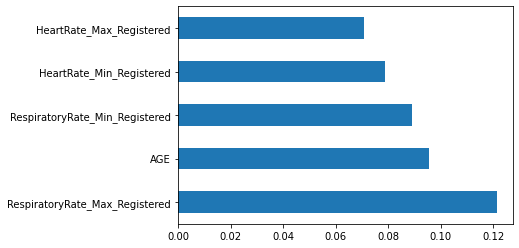

In [691]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(5).plot(kind='barh')

- **XGBOOST**

In [692]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [693]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted')))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.73
precision: 0.67
recall: 0.73
f1_score: 0.67


The 5 most important features:

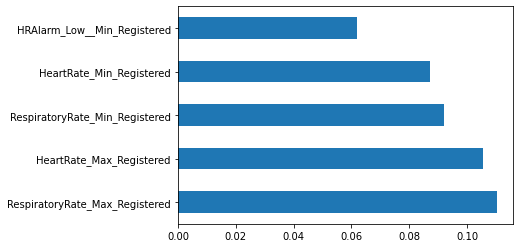

In [694]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(5).plot(kind='barh')

- **Multi-Layer Perceptron (MLP)** 

In [695]:
model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(8, 2), max_iter = 500, random_state=42)

model.fit(X,y)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [696]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted', labels=np.unique(predictions))))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.64
precision: 0.64
recall: 0.64
f1_score: 0.50


Our best model was the XGBOOST, with an accuracy of 73%, precision of 67%, recall of 73% and a f1_score of 67%.

### Disease \#5: `Acute kidney failure, unspecified`

In [697]:
DISEASE = 5849 # ICD9 code

Let's start by gathering information about the patients that have this disease, namely `gender`, `age`, `insurance`, `language`, `religion`, `marital status` and `ethnicity`. 

In [698]:
df = BQ_CLIENT.query(
  '''
    SELECT A.HADM_ID, GENDER, GREATEST(0,CAST(TIMESTAMP_DIFF(ADMITTIME, DOB, DAY)/365 - 0.5 AS INTEGER)) as AGE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
    FROM `{0}.icu.admissions` A
    INNER JOIN `{0}.icu.patients` P 
    ON P.SUBJECT_ID = A.SUBJECT_ID
    INNER JOIN `{0}.icu.diagnoses_icd` D
    ON P.SUBJECT_ID = D.SUBJECT_ID
    WHERE ICD9_CODE = '{1}'
    GROUP BY A.HADM_ID, GENDER, AGE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
    ORDER BY HADM_ID
  '''.format(PROJECT_ID, DISEASE)
).result().to_dataframe()
df = df[df.AGE.between(0, 120)]
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY
0,100001,F,35,Private,ENGL,PROTESTANT QUAKER,DIVORCED,WHITE
1,100018,M,55,Private,ENGL,PROTESTANT QUAKER,MARRIED,WHITE
2,100020,M,58,Private,ENGL,CATHOLIC,MARRIED,WHITE
3,100035,M,36,Medicaid,SPAN,NOT SPECIFIED,SINGLE,HISPANIC OR LATINO
4,100037,M,58,Private,ENGL,PROTESTANT QUAKER,MARRIED,WHITE
...,...,...,...,...,...,...,...,...
13603,199972,M,78,Medicare,ENGL,CATHOLIC,MARRIED,WHITE
13605,199992,F,85,Medicare,ENGL,JEWISH,SINGLE,WHITE
13606,199994,F,58,Medicare,None,CATHOLIC,SINGLE,WHITE
13607,199995,M,23,Private,ENGL,PROTESTANT QUAKER,SINGLE,WHITE


Let's now get the measurements for the most common ones. 

We will get a value for each label. 

When there's more than one value, in the same admission, we will consider the min and max value measured.

In [699]:
for index, row in items.iterrows():
  if index == 8: break
  measurement = BQ_CLIENT.query(
    '''
        SELECT HADM_ID, MIN(VALUE) AS {0}_Min_Registered, MAX(VALUE) AS {0}_Max_Registered
        FROM `{1}.icu.chartevents` C
        WHERE HADM_ID IN ({2}) AND ITEMID IN ({3}) 
        GROUP BY HADM_ID
        ORDER BY HADM_ID
    '''.format(row.LABEL.replace(" ", "").replace("[", "_").replace("]", "_"),
              PROJECT_ID, 
              ','.join(map(lambda i: str(i), list(df.HADM_ID))),
              ','.join(map(lambda i: str(i), list(row.ITEMIDS))))
  ).result().to_dataframe()
  df = pd.merge(df, measurement, on="HADM_ID")
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,...,HRAlarm_Low__Min_Registered,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered
0,100038,F,57,Medicaid,SPAN,CATHOLIC,SINGLE,HISPANIC OR LATINO,61,72,...,50,50,125,125,1,1,100,99,Full Code,Full Code
1,100060,F,48,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,63,97,...,50,50,150,150,1,1,100,99,Full Code,Full Code
2,100065,M,59,Private,ENGL,NOT SPECIFIED,MARRIED,BLACK/AFRICAN AMERICAN,70,90,...,50,50,120,120,1,1,100,99,Full Code,Full Code
3,100132,F,74,Medicare,None,JEWISH,MARRIED,BLACK/AFRICAN AMERICAN,100,99,...,50,60,120,120,1,1,100,99,Full Code,Full Code
4,100137,M,81,Medicare,ENGL,JEWISH,MARRIED,WHITE,47,77,...,50,50,120,120,1,1,100,99,Full Code,Full Code
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257,199895,M,81,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,28,86,...,20,55,100,100,1,1,100,99,Full Code,Full Code
4258,199900,F,61,Private,ENGL,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,100,99,...,50,60,120,120,1,1,100,99,Full Code,Full Code
4259,199919,F,65,Private,None,PROTESTANT QUAKER,MARRIED,UNKNOWN/NOT SPECIFIED,106,98,...,55,60,120,120,1,1,100,99,Do Not Resuscita,Full Code
4260,199963,M,70,Medicare,None,OTHER,SINGLE,UNKNOWN/NOT SPECIFIED,100,99,...,50,60,100,120,1,1,100,99,Full Code,Full Code


In [700]:
df = df.dropna()
df.shape

(2677, 24)

Let's now get the target variable, `LOS`:

In [701]:
results = BQ_CLIENT.query(
  '''
      SELECT HADM_ID, AVG(LOS) AS LOS
      FROM `{0}.icu.icustays`
      WHERE HADM_ID IN ({1})
      GROUP BY HADM_ID
      ORDER BY HADM_ID
  '''.format(PROJECT_ID, 
             ','.join(map(lambda i: str(i), list(df.HADM_ID))))
).result().to_dataframe()

results.LOS = np.digitize(results.LOS,[4,7])

df = pd.merge(df, results, on="HADM_ID")

results.LOS

0       0
1       0
2       0
3       0
4       1
       ..
2670    0
2671    2
2672    0
2673    2
2674    0
Name: LOS, Length: 2675, dtype: int64

Let's convert the categorical features to numeric features, since <em>Scikit Learn</em> only works with numeric data:

In [702]:
cols = ['GENDER', 'AGE', 'INSURANCE',
        'HeartRhythm_Min_Registered',  'HeartRhythm_Max_Registered',
        'CodeStatus_Min_Registered', 'CodeStatus_Max_Registered'
]

for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))
df

,HADM_ID,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,...,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered,LOS
0,0,0,38,1,31,2,3,10,63,40,...,8,8,7,0,0,3,13,6,3,0
1,1,0,29,2,16,2,0,23,65,65,...,8,13,14,0,0,3,13,6,3,0
2,2,1,40,3,16,10,1,7,72,58,...,8,7,5,0,0,3,13,6,3,0
3,3,1,62,2,16,8,1,23,49,45,...,8,7,5,0,0,3,13,6,3,0
4,4,1,69,2,16,8,1,23,44,43,...,8,4,5,0,0,3,13,6,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,2670,1,55,2,16,2,5,23,55,49,...,8,7,5,0,0,31,12,6,3,0
2671,2671,1,43,3,16,2,1,26,1,67,...,12,7,5,0,0,3,13,6,3,2
2672,2672,1,62,2,16,2,5,23,32,54,...,10,1,0,0,0,3,13,6,3,0
2673,2673,0,42,3,16,12,0,7,1,67,...,12,7,5,0,0,3,13,6,3,2


We can already drop the `HADM_ID` feature and also normalize the data:

In [703]:
df = df.drop('HADM_ID', axis=1)

df.loc[:, df.columns != 'LOS'] = pd.DataFrame(MinMaxScaler().fit_transform(df.loc[:, df.columns != 'LOS']), columns=df.loc[:, df.columns != 'LOS'].columns)

Final glimpse on the data set:

In [704]:
df

,GENDER,AGE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HeartRate_Min_Registered,HeartRate_Max_Registered,RespiratoryRate_Min_Registered,...,HRAlarm_Low__Max_Registered,HRAlarm_High__Min_Registered,HRAlarm_High__Max_Registered,calprevflg_Min_Registered,calprevflg_Max_Registered,SpO2_Min_Registered,SpO2_Max_Registered,CodeStatus_Min_Registered,CodeStatus_Max_Registered,LOS
0,0.0,0.542857,0.25,0.939394,0.133333,0.6,0.370370,0.732558,0.597015,0.444444,...,0.307692,0.333333,0.184211,0.0,0.0,0.073171,1.000000,0.857143,0.6,0
1,0.0,0.414286,0.50,0.484848,0.133333,0.0,0.851852,0.755814,0.970149,0.055556,...,0.307692,0.541667,0.368421,0.0,0.0,0.073171,1.000000,0.857143,0.6,0
2,1.0,0.571429,0.75,0.484848,0.666667,0.2,0.259259,0.837209,0.865672,0.444444,...,0.307692,0.291667,0.131579,0.0,0.0,0.073171,1.000000,0.857143,0.6,0
3,1.0,0.885714,0.50,0.484848,0.533333,0.2,0.851852,0.569767,0.671642,0.055556,...,0.307692,0.291667,0.131579,0.0,0.0,0.073171,1.000000,0.857143,0.6,0
4,1.0,0.985714,0.50,0.484848,0.533333,0.2,0.851852,0.511628,0.641791,0.055556,...,0.307692,0.166667,0.131579,0.0,0.0,0.073171,1.000000,0.857143,0.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,1.0,0.785714,0.50,0.484848,0.133333,1.0,0.851852,0.639535,0.731343,0.388889,...,0.307692,0.291667,0.131579,0.0,0.0,0.756098,0.923077,0.857143,0.6,0
2671,1.0,0.614286,0.75,0.484848,0.133333,0.2,0.962963,0.011628,1.000000,0.055556,...,0.461538,0.291667,0.131579,0.0,0.0,0.073171,1.000000,0.857143,0.6,2
2672,1.0,0.885714,0.50,0.484848,0.133333,1.0,0.851852,0.372093,0.805970,0.111111,...,0.384615,0.041667,0.000000,0.0,0.0,0.073171,1.000000,0.857143,0.6,0
2673,0.0,0.600000,0.75,0.484848,0.800000,0.0,0.259259,0.011628,1.000000,0.055556,...,0.461538,0.291667,0.131579,0.0,0.0,0.073171,1.000000,0.857143,0.6,2


Let's now train our models, with a Random Forest, XGBoost and Multi-Layer Perceptron classifier.

Firstly, let's start by spliting our data set into a training and testing set.

In [705]:
X = df.drop(["LOS"], axis=1)
y = df["LOS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- **Random Forests**

In [706]:
model = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [707]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted')))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.73
precision: 0.68
recall: 0.73
f1_score: 0.68


The 5 most important features:

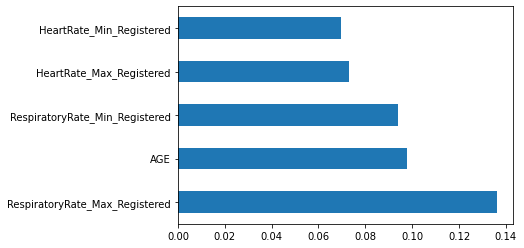

In [708]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(5).plot(kind='barh')

- **XGBOOST**

In [709]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [710]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted')))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.74
precision: 0.72
recall: 0.74
f1_score: 0.68


The 5 most important features:

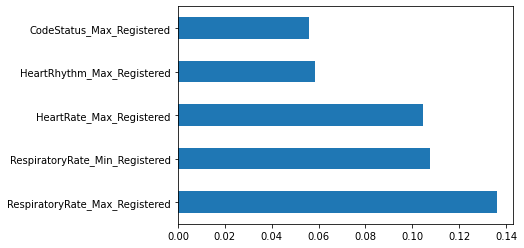

In [711]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(5).plot(kind='barh')

- **Multi-Layer Perceptron (MLP)** 

In [712]:
model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(8, 2), max_iter = 500, random_state=42)

model.fit(X,y)

predictions = model.predict(X_test)

Let's acess the performance of our model:

In [713]:
print('accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(metrics.precision_score(y_test, predictions, average='weighted', labels=np.unique(predictions))))
print('recall: {:.2f}'.format(metrics.recall_score(y_test, predictions, average='weighted')))
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, predictions, average='weighted')))

accuracy: 0.64
precision: 0.64
recall: 0.64
f1_score: 0.51


For this desease, our best model was the XGBOOST, with an accuracy of 74%, a precision of 72%, a recall of 74% and a f1_score of 68%.

## Conclusion

The biggest challenge was in the data pre-processing and feature engineering part, specially, dealing with the size of the data set. Also, the reality is that it is not trivial to predict the length of the stay of an admission, since it depends on a high number of variables, which are not clear to describe.

Future work could pass from adding new information, such as the hospital capacity and if it is overcrowded, since the length of stays tend to be shorter, if there is a shortage of material and/or manpower.

Also, if we wanted to target a specific disease, we could improve measurements that we know that are relevant to the disease. For instance, for the disease <em>hypertension</em>, measuraments related to blood pressure, such as systolic and diastolic pressure, CO and CI pressure (ITEMIDS from 226849 to 226859) are known to be important and therefore may have great power predicting the length of the stay, which was our original idea, but we had insufficient data to do this kind of analysis.